# Title 

In [1]:
#imports
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

## <u><b> Part 1 </b></u>

### Adjusting the data for the program


#### Loading the data

In [2]:
rnd = np.random.randint(1000)
df = pd.read_csv(r'data/high_diamond_ranked_10min.csv')
df.head()


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

#### Looking for missing values

In [4]:
df.isna().values[df.isna().values==True]

array([], dtype=bool)

## <u><b> Part 2 </b></u>

### Cleaning and scaling the data

#### Removing known useless data 
We know that the game ID has 0 impact on who wins the game so we drop it

In [5]:
df.drop(columns=["gameId"],inplace=True)
data = df.copy()

#### Visualization of the correlations between the columns

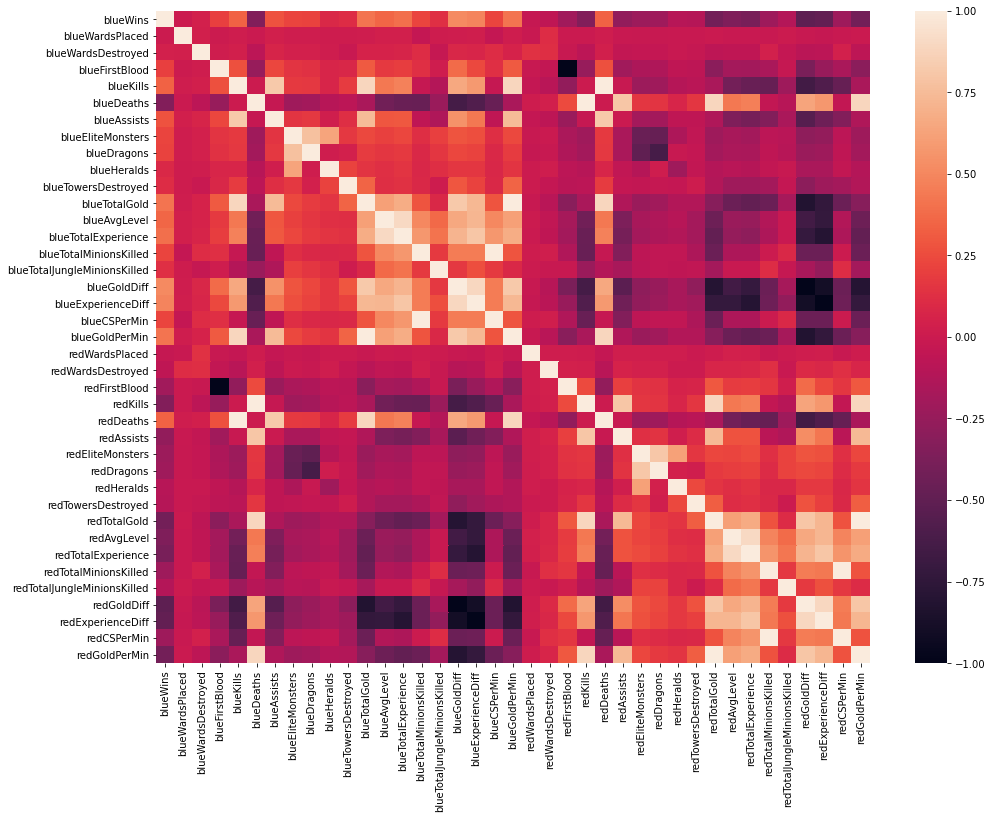

In [6]:
matrix = data.corr()
plt.figure(figsize=(16,12))
sns.heatmap(matrix)
plt.show()

#### Remove correlated features
Highly correlated data can slow our model while not offering any precision, especialy in games like League of Legends where once you have more kills you (usualy) have more gold that lets you get even more kills and objectives. Some features like redDeaths and blueKills are perfectly correlated so we don't need one of them at all.

In [7]:
def correlations(D,mainCorr=None, limit=0.95):
    #dataframe of boolean values of D dataFrame correlations, true iff |value|>=0.95
    highCorrColl = abs(D.corr())>=limit
    colls = []
    remove = []
    for coll in highCorrColl.columns:
        #we might delete a column we didn't visit
        if coll in highCorrColl.columns:
            #if any of the values is true and its not the same index as the column (since at (x,x) we always have a value of 1 so it will always be true)
            if highCorrColl[coll][highCorrColl[coll].index!=coll].any():
                #mainCorr is a series of correlation values of the main feature and the rest of the columns 
                if mainCorr is not None:
                    #get all the elements that have a high correlation with coll (including coll, (coll,coll) is always true) 
                    correl = highCorrColl[coll]
                    correl = correl[correl==True]

                    #get the representation of correl in the correlation series mainCorr
                    correlVals = mainCorr[correl.index]
                    
                    #indexs to remove, we want to keep the ones with the highest correlations to mainCorr/"blueWins"
                    removeIDX = correlVals[abs(correlVals).idxmax() != correlVals.index].index
                    highCorrColl = highCorrColl.drop(columns = removeIDX).drop(index = removeIDX)
                    remove.extend(removeIDX)
                else:
                    #if mainCorr was not passed, drop coll
                    highCorrColl = highCorrColl.drop(columns = coll).drop(index = coll)
                    remove.append(coll)
    return D.drop(columns=remove)

#custom class for pipeline
class FilterCorrelations(BaseEstimator, TransformerMixin):
    def __init__(self,mainCorr=None,limit=0.95):
        self.mainCorr=mainCorr
        self.limit = limit
    def fit(self, Data):
        return self
    def transform(self,Data):
        return correlations(Data,mainCorr=self.mainCorr, limit=self.limit)

#### Scale data
We will use sklearn's standard scaler since our data has many outliers

In [8]:
#custom class for pipeline
class Scale(BaseEstimator, TransformerMixin):
    def fit(self, Data):
        return self
    def transform(self,Data):
        tempDF = Data.copy()
        Data = StandardScaler().fit_transform(Data)
        return pd.DataFrame(Data,columns=tempDF.columns,index=tempDF.index)

#### Find labels wihout correlation with winning

In [9]:
(abs(matrix["blueWins"])<=0).any()

False

In [10]:
#add graphs

## <u><b> Part 3 </b></u>

### Splitting data to train/test and making models

In [11]:
exp = df["blueWins"]
data = df.drop(columns=["blueWins"])
#data = df[["blueGoldPerMin","blueGoldDiff","blueAvgLevel","blueTotalExperience","blueFirstBlood","redTotalJungleMinionsKilled","redGoldPerMin","blueDragons"]]

In [12]:
trainD, testD, trainE, testE = train_test_split(data, exp,random_state=rnd)
pipe = Pipeline([
    ("handle_correlations",FilterCorrelations(mainCorr=df.corr()["blueWins"],limit=0.95)),
    ('scaler',Scale())
])

In [13]:
trainD = pipe.fit_transform(trainD)
testD = pipe.transform(testD)

#### Finding lables with high importance
Since we have so many labels, we could try and remove some so the program could run faster without loss of accuracy

In [14]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=rnd)
forest.fit(trainD,trainE)

ExtraTreesClassifier(n_estimators=250, random_state=376)

<AxesSubplot:ylabel='label'>

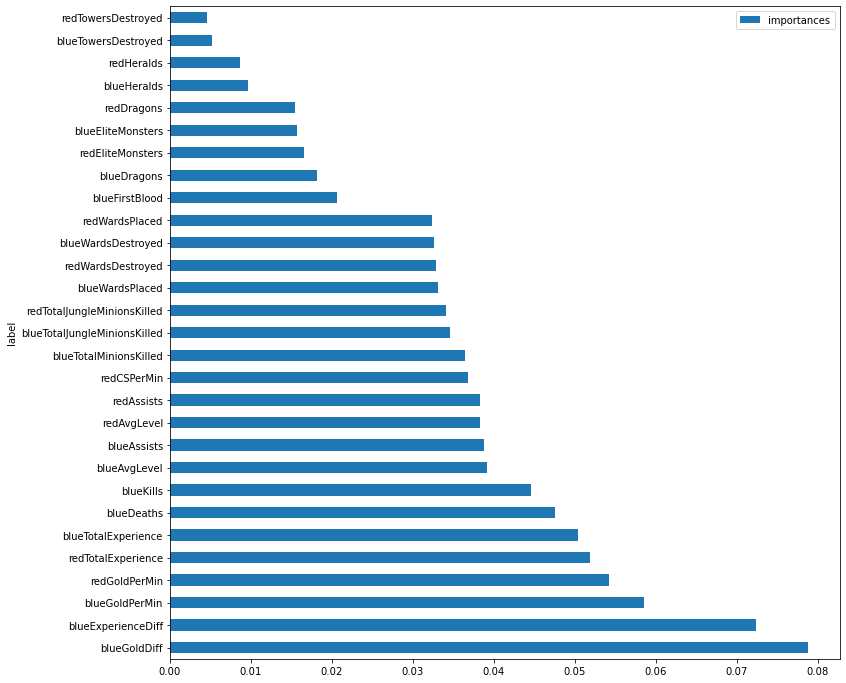

In [15]:
importanceDF = pd.DataFrame({"label":trainD.columns, "importances":forest.feature_importances_})
importanceDF.sort_values(by="importances",ascending=False,inplace=True)
importanceDF.plot(x="label",y="importances",kind="barh",figsize=(12,12))

In [16]:
trainD.drop(columns=trainD.columns.difference(importanceDF.head(8)["label"]),inplace=True)
testD.drop(columns=testD.columns.difference(importanceDF.head(8)["label"]),inplace=True)
importanceDF.head(8)["label"]

14           blueGoldDiff
15     blueExperienceDiff
16         blueGoldPerMin
28          redGoldPerMin
25     redTotalExperience
11    blueTotalExperience
4              blueDeaths
3               blueKills
Name: label, dtype: object

In [17]:
trainD.head()

,blueKills,blueDeaths,blueTotalExperience,blueGoldDiff,blueExperienceDiff,blueGoldPerMin,redTotalExperience,redGoldPerMin
8387,-0.057531,0.620926,0.371682,-0.201782,-0.092962,0.301370,0.520760,0.638020
3702,-0.387191,-0.394699,-1.022695,-0.527879,-0.801168,-0.832023,0.256593,0.013599
4261,0.272128,-0.056157,0.958875,0.689712,0.131364,0.415034,0.750146,-0.704385
7708,-1.376171,-0.056157,-1.436211,-0.729864,-0.916698,-1.562070,0.027207,-0.401796
5054,2.579748,-1.071781,1.851243,2.390366,2.456994,2.296660,-2.073704,-1.564374


### KNN model


#### K=5
This will be our baseline model, we will try to get better results

In [20]:
knn5_clf = KNeighborsClassifier(n_neighbors=5)
knn5_clf.fit(trainD,trainE)
knn5_pred = knn5_clf.predict(testD)

In [19]:
print("Accuracy:",accuracy_score(testE,knn5_pred))
print(classification_report(testE,knn5_pred))

Accuracy: 0.6927125506072874
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1260
           1       0.69      0.68      0.69      1210

    accuracy                           0.69      2470
   macro avg       0.69      0.69      0.69      2470
weighted avg       0.69      0.69      0.69      2470



#### Paramater tuning the for KNN model

In [36]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
#Parameters we want to use in order to find the best KNN model
param_grid=[
    {'n_neighbors':np.arange(1,31),'weights':["uniform","distance"]}
]
#change n_jobs for faster/slower performance

gridSearch = RandomizedSearchCV(knn_clf, param_grid, n_iter=20, scoring='accuracy', return_train_score=True,verbose=4,n_jobs=-1,random_state=rnd)

In [37]:
gridSearch.fit(trainD,trainE)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                         'weights': ['uniform', 'distance']}],
                   random_state=376, return_train_score=True,
                   scoring='accuracy', verbose=4)

In [38]:
uniforms = []
distances = []
for i in range(len(gridSearch.cv_results_['params'])):
    res = gridSearch.cv_results_['params'][i]
    #make a dictionary with {n_neighbors,weights,score} and append it in the right list
    res['score'] = gridSearch.cv_results_["mean_test_score"][i]
    if res["weights"]=="uniform": 
        uniforms.append(res)
    else:
        distances.append(res)
models = np.asarray([uniforms,distances])

Visualizing the performance of the models

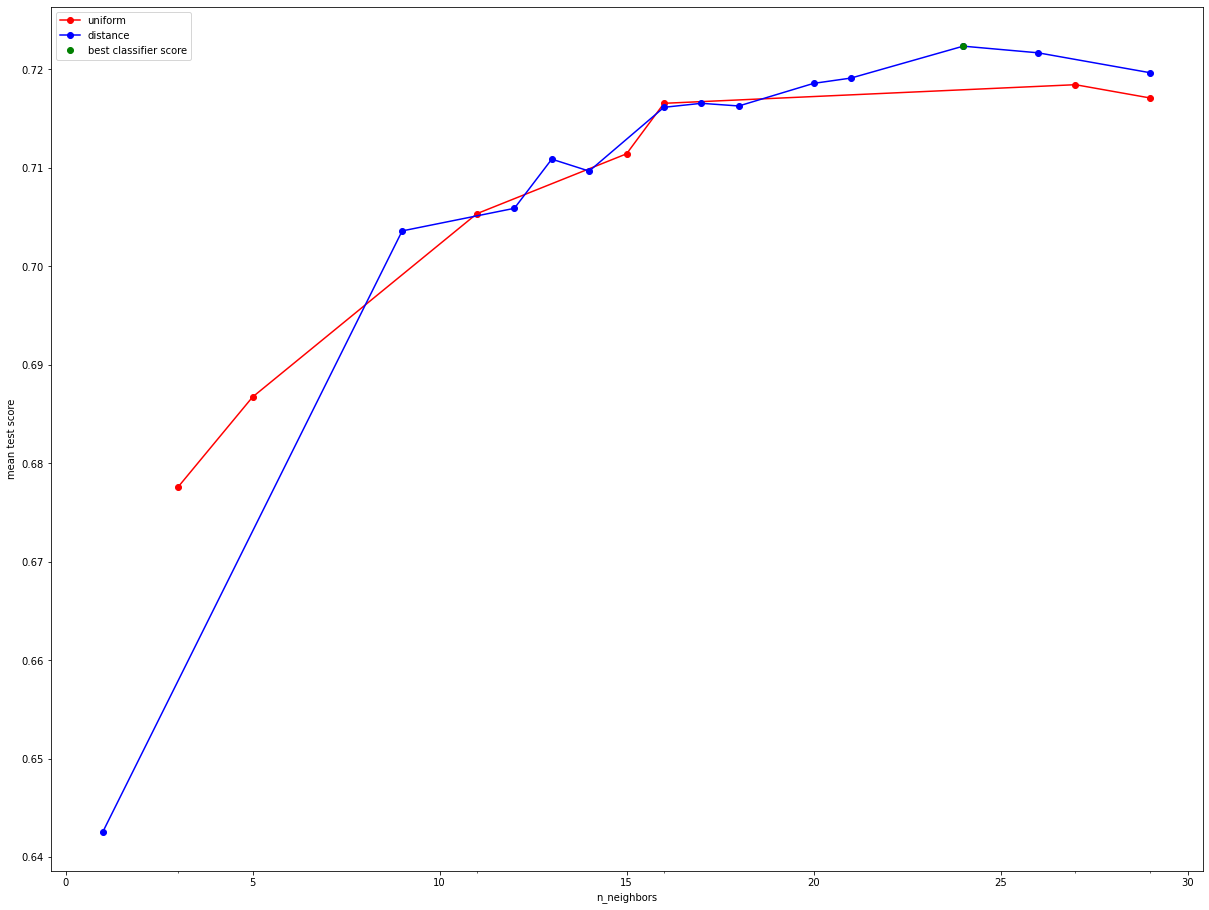

In [39]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_axes([0,0,1,1])
df1 = pd.DataFrame(models[0]).sort_values(by="n_neighbors")
df2 = pd.DataFrame(models[1]).sort_values(by="n_neighbors")
ax.plot(df1["n_neighbors"],df1["score"],"ro-")
ax.plot(df2["n_neighbors"],df2["score"],"bo-")
#place a green dot at the best classifier
ax.plot(gridSearch.best_estimator_.n_neighbors,gridSearch.best_score_,"go")
ax.set_ylabel("mean test score")
ax.set_xlabel("n_neighbors")
ax.legend(labels=["uniform","distance","best classifier score"])
ax.set_xticks([i['n_neighbors'] for i in models[0]] ,[i['score'] for i in models[0]])
plt.show()

In [40]:
models[0]

[{'weights': 'uniform', 'n_neighbors': 11, 'score': 0.705355282977089},
 {'weights': 'uniform', 'n_neighbors': 15, 'score': 0.7114303444165913},
 {'weights': 'uniform', 'n_neighbors': 5, 'score': 0.6867305254774603},
 {'weights': 'uniform', 'n_neighbors': 16, 'score': 0.7165590051584578},
 {'weights': 'uniform', 'n_neighbors': 3, 'score': 0.6775529172487131},
 {'weights': 'uniform', 'n_neighbors': 29, 'score': 0.717099545206443},
 {'weights': 'uniform', 'n_neighbors': 27, 'score': 0.718449619608154}]

#### Fitting KNN model

In [41]:
knn_clf = gridSearch.best_estimator_
knn_clf.fit(trainD,trainE)
knn_pred = knn_clf.predict(testD)
knn_clf

KNeighborsClassifier(n_neighbors=24, weights='distance')

In [42]:
print("Accuracy:",accuracy_score(testE,knn_pred))
print(classification_report(testE,knn_pred))

Accuracy: 0.7129554655870445
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1228
           1       0.72      0.71      0.71      1242

    accuracy                           0.71      2470
   macro avg       0.71      0.71      0.71      2470
weighted avg       0.71      0.71      0.71      2470



### SVC model

#### Paramater tuning for the SVC model

In [43]:
svc_clf = SVC(random_state=rnd)
#Parameters we want to use in order to find the best KNN model
param_grid=[
    {'C':np.linspace(0.9,1.1,30),"gamma":["scale","auto"]}
]
#change n_jobs for faster/slower performance
gridSearch = RandomizedSearchCV(svc_clf, param_grid, n_iter=20, scoring='accuracy', return_train_score=True,verbose=4,n_jobs=-1,random_state=rnd)


In [44]:
gridSearch.fit(trainD,trainE)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=SVC(random_state=376), n_iter=20, n_jobs=-1,
                   param_distributions=[{'C': array([0.9       , 0.90689655, 0.9137931 , 0.92068966, 0.92758621,
       0.93448276, 0.94137931, 0.94827586, 0.95517241, 0.96206897,
       0.96896552, 0.97586207, 0.98275862, 0.98965517, 0.99655172,
       1.00344828, 1.01034483, 1.01724138, 1.02413793, 1.03103448,
       1.03793103, 1.04482759, 1.05172414, 1.05862069, 1.06551724,
       1.07241379, 1.07931034, 1.0862069 , 1.09310345, 1.1       ]),
                                         'gamma': ['scale', 'auto']}],
                   random_state=376, return_train_score=True,
                   scoring='accuracy', verbose=4)

In [45]:
scale = []
auto = []
for i in range(len(gridSearch.cv_results_['params'])):
    res = gridSearch.cv_results_['params'][i]
    #make a dictionary with {n_neighbors,weights,score} and append it in the right list
    res['score'] = gridSearch.cv_results_["mean_test_score"][i]
    if res["gamma"]=="scale":
        scale.append(res)
    else:
        auto.append(res)
models = np.asarray([scale,auto])

#### Visualizing the performance of the models

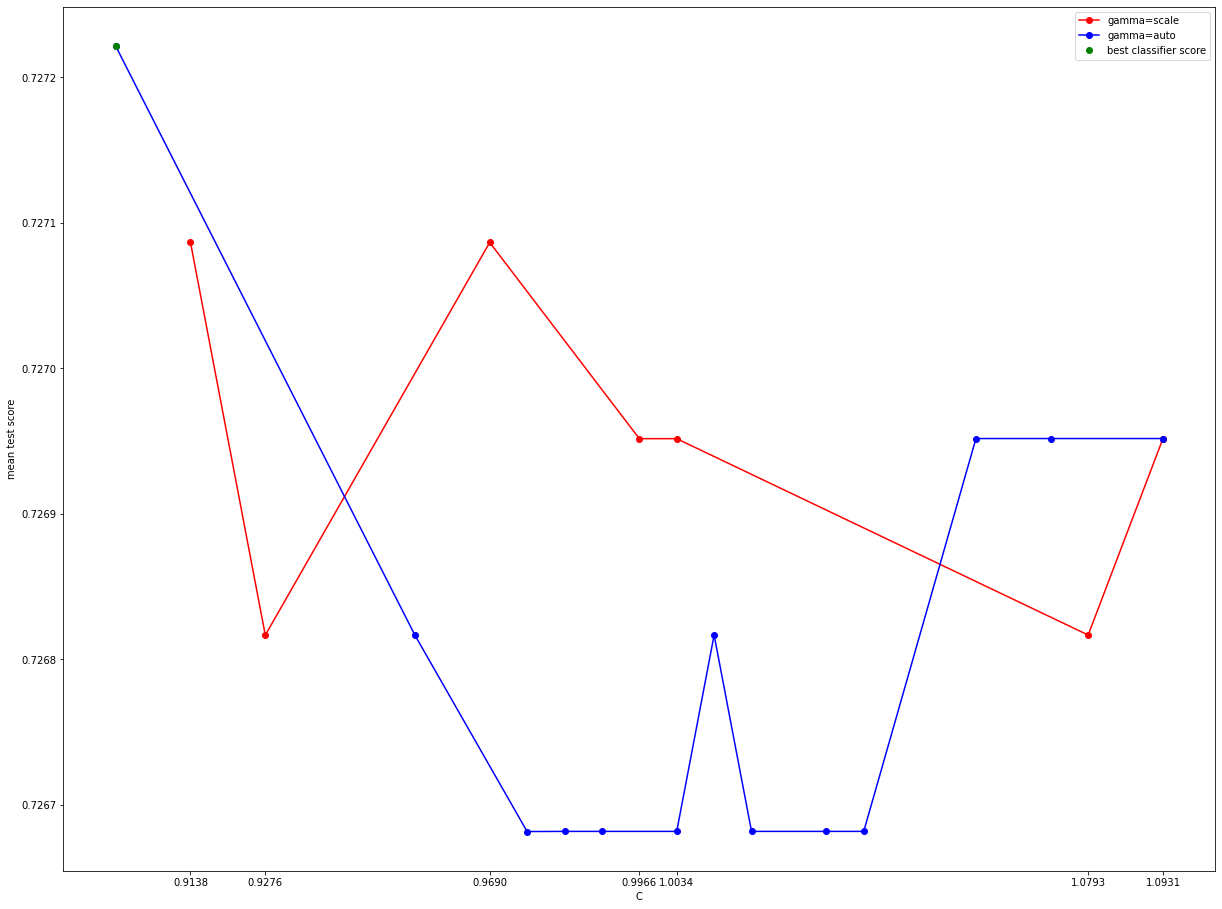

In [51]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_axes([0,0,1,1])
#ax.bar([i['C'] for i in models[0]] ,[i['score'] for i in models[0]],width=0.1)
#ax.bar([i['C'] for i in models[1]] ,[i['score'] for i in models[1]],width=0.1)
df1 = pd.DataFrame(models[0]).sort_values(by="C")
df2 = pd.DataFrame(models[1]).sort_values(by="C")
ax.plot(df1["C"],df1["score"],"ro-")
ax.plot(df2["C"],df2["score"],"bo-")
#place a green dot at the best classifier
ax.plot(gridSearch.best_estimator_.C,gridSearch.best_score_,"go")
ax.set_ylabel("mean test score")
ax.set_xlabel("C")
ax.legend(labels=["gamma=scale","gamma=auto","best classifier score"])
ax.set_xticks([i['C'] for i in models[0]])
plt.show()

Fitting SVC model

In [52]:
print(gridSearch.best_estimator_.fit_status_)
svc_clf = gridSearch.best_estimator_
svc_clf.fit(trainD,trainE)
svc_pred = knn_clf.predict(testD)
svc_clf

0


SVC(C=0.9, gamma='auto', random_state=376)

In [53]:
print("Accuracy:",accuracy_score(testE,svc_pred))
print(classification_report(testE,svc_pred))

Accuracy: 0.7129554655870445
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1228
           1       0.72      0.71      0.71      1242

    accuracy                           0.71      2470
   macro avg       0.71      0.71      0.71      2470
weighted avg       0.71      0.71      0.71      2470



## <u><b> Part 4 </b></u>

### Results

#### Confusion matrix

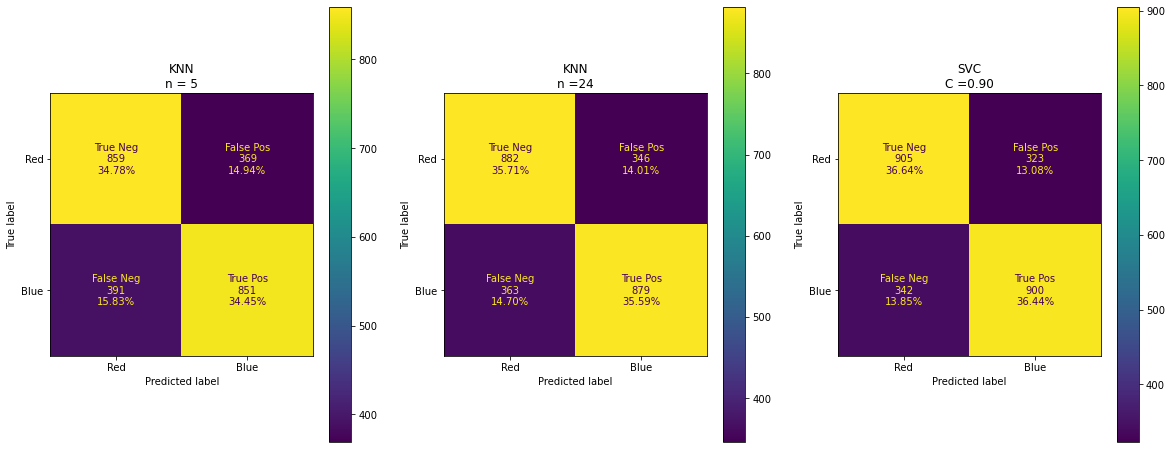

In [49]:
fig,axes = plt.subplots(ncols=3,figsize=(20,8),sharex=True)
cms = [None,None,None]
cms[0] = plot_confusion_matrix(knn5_clf,testD,testE,ax=axes[0],display_labels=["Red","Blue"])
cms[1] = plot_confusion_matrix(knn_clf,testD,testE,ax=axes[1],display_labels=["Red","Blue"])
cms[2] = plot_confusion_matrix(svc_clf,testD,testE,ax=axes[2],display_labels=["Red","Blue"])
vals = [["True Neg","False Pos"],["False Neg","True Pos"]]
for cm in cms:
    text = [[cm.text_[i][j].get_text() for j in range(len(cm.text_[i]))] for i in range(len(cm.text_))]
    for i in range(len(text)):
        for t in range(len(text[i])):
            txt = vals[i][t] + "\n" + text[i][t] + "\n" + '{0:.2f}'.format(100*(int(text[i][t])/len(testE)))+"%"
            cm.text_[i][t].set_text(txt)
        
axes[0].title.set_text("KNN\nn = 5")
axes[1].title.set_text("KNN\nn ="+str(knn_clf.n_neighbors))
axes[2].title.set_text("SVC\nC ="+str('{0:.2f}'.format(svc_clf.C)))



#### ROC curve

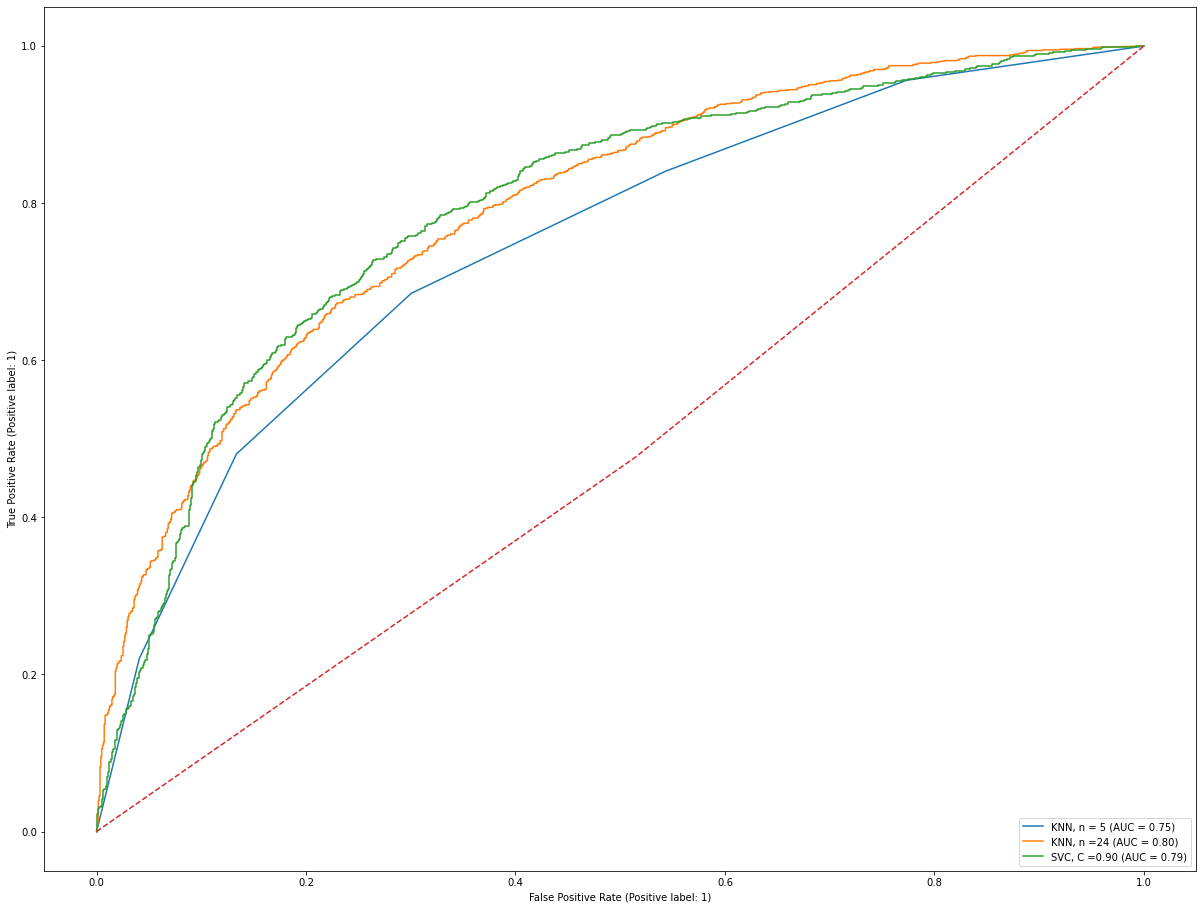

In [50]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_axes([0,0,1,1])
falsePosRate, truePosRate, _ = roc_curve(testE,np.random.choice([0,1],size=len(testE)))
plot_roc_curve(knn5_clf,testD,testE,ax=ax,name="KNN, n = 5")
plot_roc_curve(knn_clf,testD,testE,ax=ax,name="KNN, n ="+str(knn_clf.n_neighbors))
plot_roc_curve(svc_clf,testD,testE,ax=ax,name="SVC, C ="+str('{0:.2f}'.format(svc_clf.C)))
ax.plot(falsePosRate, truePosRate, linestyle='--')

In [ ]:
imp = permutation_importance(svc_clf,trainD,trainE,n_repeats=1)


In [ ]:

d = [[gridSearch.cv_results_["params"][i],gridSearch.cv_results_["rank_test_score"][i],gridSearch.cv_results_["mean_test_score"][i]] for i in range(len(gridSearch.cv_results_["mean_train_score"]))]
dff2 = pd.DataFrame(d,columns=["params","rank_test_score","mean_train_score"])
dff2

In [ ]:
dff1 = pd.DataFrame(columns=["label","mean","std","importances"],data=[[trainD.columns[i],imp.importances_mean[i],imp.importances_std[i],imp.importances[i][0]] for i in range(len(trainD.columns))])
dff1.sort_values(by="importances",ascending=False,inplace=True)
dff1.plot(y="importances",kind="bar")
for i in dff1.head(8)["label"]:
    print('"'+i+'",')

In [ ]:
from sklearn.decomposition import PCA
tempdf = trainD.copy()
tempdf["blueWins"] = trainE
tempdf = tempdf.reset_index(drop=True)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(trainD)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, tempdf[['blueWins']]], axis = 1)


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['blueWins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(['Red Wins', 'Blue Wins'])
ax.grid()

In [ ]:
gridSearch.cv_results_["params"]

In [ ]:
trainE

In [ ]:
tempdf